In [1]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import hyperspy.api as hs
import ctypes
from matplotlib.patches import Circle

plt.rcParams["figure.figsize"] = (12,12)

In [2]:
def FT(img):
    return fft.ifftshift(fft.fft2(fft.fftshift(img)))

def IFT(img):
    return fft.fftshift(fft.ifft2(fft.ifftshift(img)))

In [3]:
lib = ctypes.CDLL(r"GPA.dll")
Handle = ctypes.POINTER(ctypes.c_char)
c_float_array = np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags='C_CONTIGUOUS')
c_int_array = np.ctypeslib.ndpointer(dtype=int, ndim=1, flags='C_CONTIGUOUS')

lib.createGPA.argtypes = None
lib.createGPA.restype = Handle

lib.deleteGPA.argtypes = [Handle]
lib.deleteGPA.restype = None

lib.load_FFT.argtypes = [Handle, c_float_array, c_int_array, ctypes.c_float]
lib.load_FFT.restypes = None

lib.mark_spot1.argtypes = [Handle,c_int_array, ctypes.c_int, c_float_array]
lib.mark_spot1.restypes = None

lib.mark_spot2.argtypes = [Handle,c_int_array, ctypes.c_int ,c_float_array]
lib.mark_spot2.restypes = None

lib.calc_GPA.argtypes = [Handle]
lib.calc_GPA.restypes = None

lib.apply_rotation.argtypes = [Handle, ctypes.c_float] 
lib.apply_rotation.restypes = None

lib.get.argtypes = [Handle,c_float_array,c_float_array,c_float_array,c_float_array,c_float_array,c_float_array]
lib.get.restypes = None

class GPA:    
    def __init__(self):
        self.instance = lib.createGPA()
        self.ref_load = False
        self.Sp1_marked = False
        self.Sp2_marked = False
        self.get_ready = False

    def __del__(self):
        lib.deleteGPA(self.instance)   
        
    def load_image(self,img, calibration):
        #image = np.empty(self.Npix2, dtype=np.double)
        self.dim = img.shape
        size = np.asarray(self.dim,dtype = int)
        image = np.asarray(img.flatten(), dtype = np.float32)
        lib.load_FFT(self.instance, image, size, calibration*size[0])
        self.ref_load = True
    
    def mark_spot1(self, coordinates, win_size):
        if(self.ref_load != True):
            print("Load an image first")
            return np.empty((2,2), dtype=np.float32)
        amp = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        coo = np.asarray(coordinates,dtype = int)
        lib.mark_spot1(self.instance,coo,win_size,np.asarray(amp, dtype=np.float32))
        self.Sp1_marked = True
        return amp.reshape(self.dim[0],self.dim[1])
    
    def mark_spot2(self, coordinates, win_size):
        if(self.ref_load != True):
            print("Load an image first")
            return np.empty((2,2), dtype=np.float32)
        amp = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        coo = np.asarray(coordinates,dtype = int)
        lib.mark_spot2(self.instance,coo,win_size,np.asarray(amp, dtype=np.float32))
        self.Sp2_marked = True
        return amp.reshape(self.dim[0],self.dim[1])
    
    def calc_GPA(self):
        if(self.ref_load and self.Sp1_marked and self.Sp2_marked == True):
            lib.calc_GPA(self.instance)
            self.get_ready = True
        else:
            print("Mark two diffraction spots first!")
            
    def apply_rotation(self, angle):
        lib.apply_rotation(self.instance, angle)
        
    def get(self):
        if(self.ref_load != True):
            x = np.empty((2,2), dtype=np.float32)
            print("run a calculation first!!")
            return x,x,x,x,x,x
        dxx = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        dyy = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        dxy = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        dyx = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        rot = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        shear = np.empty(self.dim[0]*self.dim[1], dtype=np.float32)
        lib.get(self.instance, dxx, dyy, dxy, dyx, rot, shear)
        dxx = dxx.reshape(self.dim[0],self.dim[1])
        dyy = dyy.reshape(self.dim[0],self.dim[1])
        dxy = dxy.reshape(self.dim[0],self.dim[1])
        dyx = dyx.reshape(self.dim[0],self.dim[1])
        rot = rot.reshape(self.dim[0],self.dim[1])
        shear = shear.reshape(self.dim[0],self.dim[1])
        return dxx, dyy, dxy, dyx, rot, shear

In [4]:
Analysis = GPA()

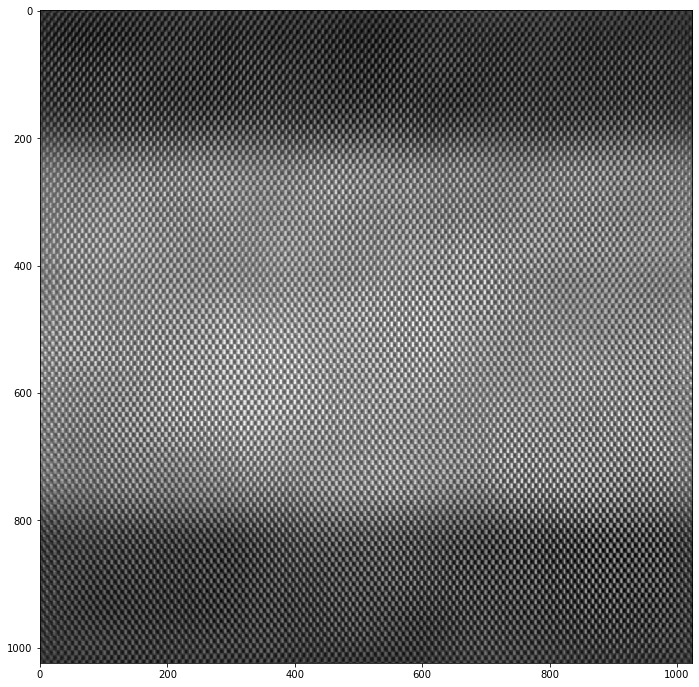

In [5]:
img = hs.load(r'GeQW2-wien-rebin.dm3')
img = np.array(img)

plt.imshow(img,interpolation='nearest', cmap='gray')

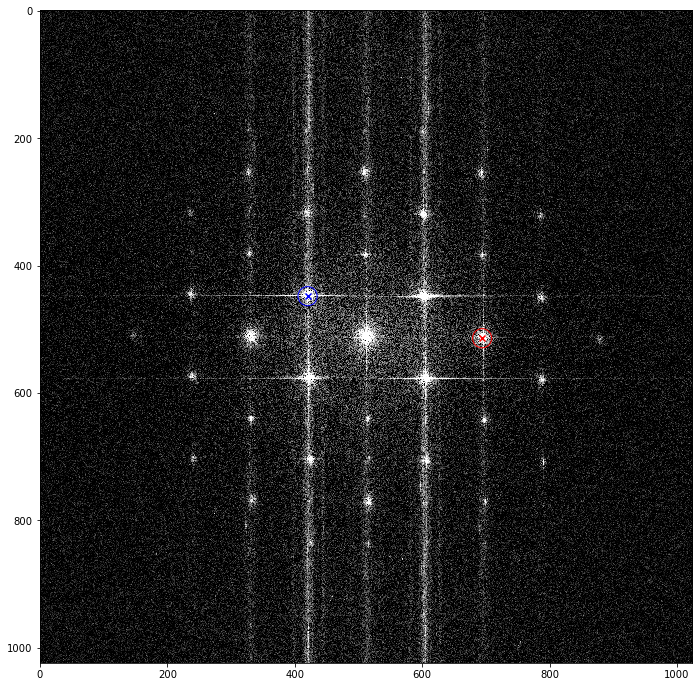

In [6]:
fft_img = np.log(abs(FT(img)))
fig,ax = plt.subplots(1)
ax.imshow(np.clip(fft_img,8,14),interpolation='nearest', cmap='gray')

win_size = 15

Sp1X = 694
Sp1Y = 514
ax.scatter(Sp1X, Sp1Y, c="red", marker="x")
circle = Circle((Sp1X, Sp1Y), win_size, facecolor='none',edgecolor="red", linewidth=1, alpha=1)
ax.add_patch(circle)

Sp2X = 420
Sp2Y = 448
ax.scatter(Sp2X, Sp2Y, c="blue", marker="x")
circle = Circle((Sp2X, Sp2Y), win_size, facecolor='none',edgecolor="blue", linewidth=1, alpha=1)
ax.add_patch(circle)

In [7]:
Analysis.load_image(img,1)

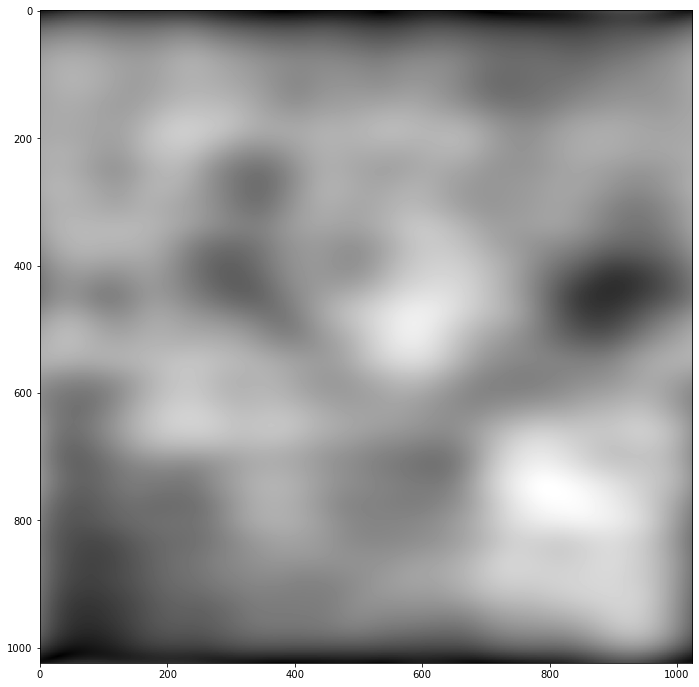

In [8]:
amp1 = Analysis.mark_spot1((Sp1X,Sp1Y),win_size)
plt.imshow(amp1,interpolation='nearest', cmap='gray')

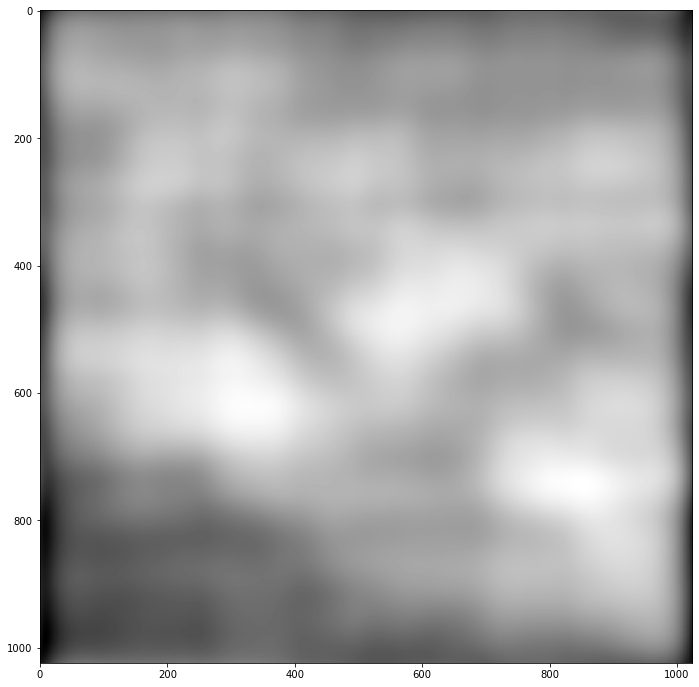

In [9]:
amp2 = Analysis.mark_spot2((Sp2X,Sp2Y),win_size)
plt.imshow(amp2,interpolation='nearest', cmap='gray')

In [10]:
Analysis.calc_GPA()
dxx, dyy, dxy, dyx, _, _ = Analysis.get()

Text(0.5, 1.0, 'e_yx')

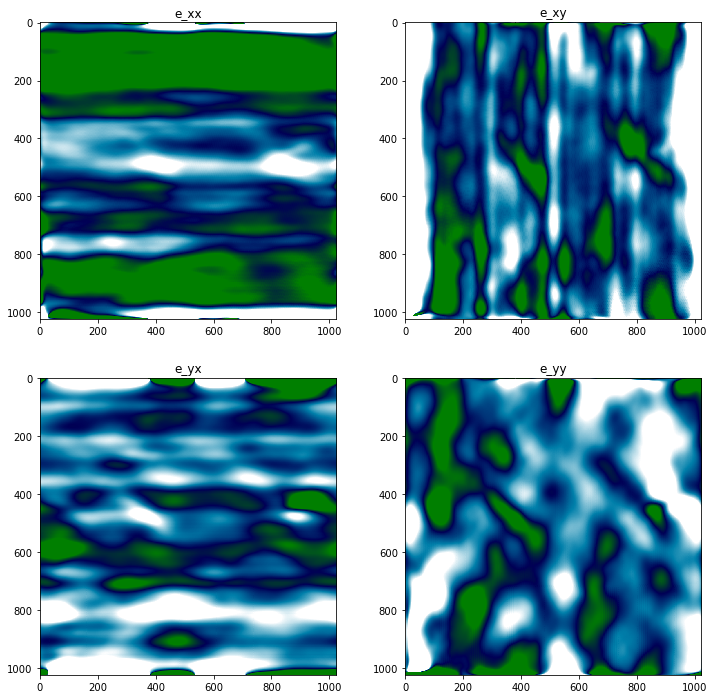

In [11]:
c = 2
cm = 'ocean'
fig,ax=plt.subplots(2,2)
M = dxx[256:768,256:768].mean()
S = dxx[256:768,256:768].std()
ax[0][0].imshow(dxx,interpolation='nearest', cmap=cm, clim=(M-c*S,M+c*S))
ax[0][0].set_title('e_xx')
M = dyy[256:768,256:768].mean()
S = dyy[256:768,256:768].std()
ax[1][1].imshow(dyy,interpolation='nearest', cmap=cm, clim=(M-c*S,M+c*S))
ax[1][1].set_title('e_yy')
M = dxy[256:768,256:768].mean()
S = dxy[256:768,256:768].std()
ax[0][1].imshow(dxy,interpolation='nearest', cmap=cm, clim=(M-c*S,M+c*S))
ax[0][1].set_title('e_xy')
M = dyx[256:768,256:768].mean()
S = dyx[256:768,256:768].std()
ax[1][0].imshow(dyx,interpolation='nearest', cmap=cm, clim=(M-c*S,M+c*S))
ax[1][0].set_title('e_yx')